# The basics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Let's use the Sun as a test case.

In [2]:
bprp = 0.82
prot = 26
prot_err = .01
log10_age = np.log10(4.56*1e9)

We'll plot the Praesepe (Angus et al, 2019) gyrochronology model over a range of ages. 

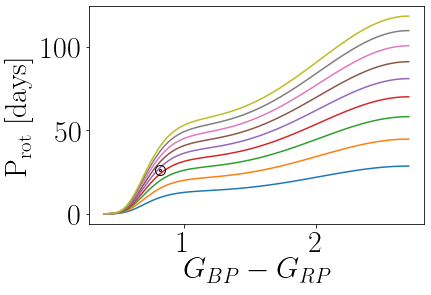

In [3]:
import stardate2 as sd2

logages = np.log10(np.arange(1, 10)*1e9)
bprps = np.linspace(.4, 2.7, 100)

for a in logages:
    plt.plot(bprps, sd2.angus_2019_model(a, bprps))

plt.plot(bprp, prot, "o", color="none", mec="k", ms=10)
plt.plot(bprp, prot, ".", color="none", mec="k", ms=4)

plt.xlabel("$G_{BP} - G_{RP}$");
plt.ylabel("$\mathrm{P_{rot}~[days]}$");

Now let's figure out what age this model would predict for the Sun. We can evaluate the posterior probability function like this:

In [4]:
import emcee

ndim, nwalkers = 1, 25
log_age_init = 9
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[prot, prot_err, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 5000);

Let's plot the posterior over age. 

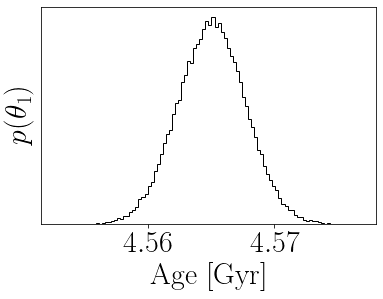

In [5]:
samples = sampler.get_chain(flat=True)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

So that's how to calculate a Bayesian gyrochronology age for star if you have it's rotation period and Gaia-color.

Now let's look at how to do the same thing using a new Gaussian process gyrochronology model.

In [8]:
gp = sd2.GP_model()
print(gp.pred_at(np.log10(4.56e9), bprp))

[26.44852901]


In [9]:
test_ages = np.linspace(9, 10, 9)
test_bprps = np.linspace(.5, 2.7, 100)

prots = np.zeros((len(test_ages), len(test_bprps)))
for i, a in enumerate(test_ages):
    for j, c in enumerate(test_bprps):
        prots[i, j] = gp.pred_at(a, c)

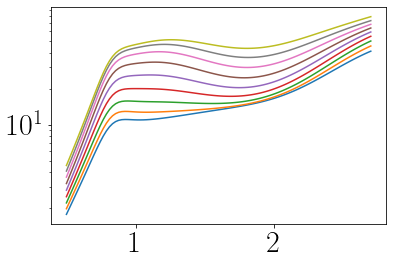

In [10]:
for i, p in enumerate(prots):
    plt.plot(test_bprps, p)

plt.yscale("log")

Infer an age:

In [14]:
ndim, nwalkers = 1, 25

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[prot, prot_err, bprp, gp.pred_at])
p0 = np.random.randn(nwalkers, ndim)*1e-2 + np.log10(5e9)
state = sampler.run_mcmc(p0, 100);
sampler.reset()
sampler.run_mcmc(state, 500);

4.43 + 0.00 - 0.00


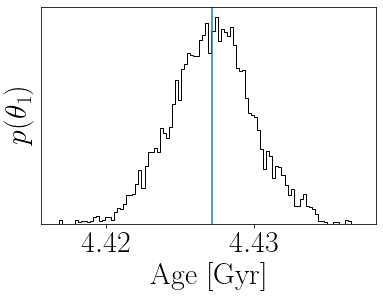

In [15]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
lin_samps = lin_samps[lin_samps > 1]
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist(lin_samps, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [75]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo
import pickle

# Load the saved GP gyro model
with open("../stardate2/gp_model_01.27.21.pkl", "rb") as f:
    model, map_soln = pickle.load(f)

with model:
    func = xo.get_theano_function_for_var(model.y_test)
    args = xo.utils.get_args_for_theano_function(map_soln)
    ind1 = model.vars.index(model.x1_test)
    ind2 = model.vars.index(model.x2_test)

c = .82
prot = 26
prot_err = .1

# with pm.Model() as age_model:
#     age = pm.Uniform("age", lower=-1, upper=3)  # Age not greater than 20 Gyr
    
#     def pred_prot(age, c):
#         args[ind1][0] = c
#         args[ind2][0] = age
#         return tt.exp(func(*args))
    
#     model_prot = pred_prot(age, c)
    
#     pm.Normal("obs", mu=model_prot, sd=prot_err, observed=prot)
    
#     map_soln = model.test_point
#     map_soln = xo.optimize(map_soln, age)

(4, 5)

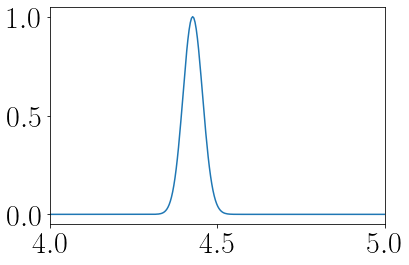

In [81]:
args[ind2] = np.linspace(-1, 3, 5000)
args[ind1] = .82 + np.zeros_like(args[ind2])
plt.plot(np.exp(args[ind2]), np.exp(-0.5 * (func(*args) - np.log(prot))**2 / (prot_err / prot) ** 2))
plt.xlim(4, 5)

In [73]:
args[ind1] = 

array([0.])

In [70]:
with pm.Model() as fitting_model:
    # x1 is color, x2 is age, y is period
    
    # Parameters to infer.
    teff_break = map_soln["teff_break"] # pm.Normal("teff_break", mu=0.9, sigma=.3)# the break in temperature (actually color)
    log_period_break_m = map_soln["log_period_break_m"]  #, mu=0.0, sd=5)         # The weight of the x term
    log_period_break_b = map_soln["log_period_break_b"]  #, mu=np.log(10), sd=5)  # The constant term
    log_smooth = map_soln["log_smooth"]  #, mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = map_soln["slope_low"]  #, mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = map_soln["slope_high"]  #, mu=0.0, sd=10.0)                      # The slope above the break
    log_s2 = map_soln["log_s2"]  #, mu=1.0, sd=10.0)                              # The log-variance of the rotation period data. 
    
    def get_log_period_break(x2):
        """
        2nd-order polynomial describing relationship between period and age.
        period = m*logage + b
        """
        return log_period_break_m * (x2 - model.x2_min) + log_period_break_b
    
    # Mean model
    def get_mean_model(x1, x2):
        """
        Predict the period at given values of color and age.
        Use a smoothed broken power law for the period - color relation.
        Use get_log_period_break for the period - age relation.
        """
        delta = x1 - teff_break
        brk = get_log_period_break(x2)  # Get the period at this age
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
        
    # GP parameters
    log_amp = map_soln["log_amp"]  #pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = map_soln["log_ell1"]  #pm.Normal("log_ell1", mu=0.0, sigma=10., shape=2)
    
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - model.mu1) / model.sd1, (x2 - model.mu2) / model.sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = tt.stack(((xp1 - model.mu1) / model.sd1, (xp2 - model.mu2) / model.sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K

    log_age = pm.Uniform("log_age", lower=-1, upper=3, shape=(1,))
    c = np.array([.82])
    prot = 26
    prot_err = .1
        
    K_test = get_K(model.x1, model.x2, c, log_age)
    log_period_model = pm.Deterministic("log_period_model", tt.dot(K_test, map_soln["alpha"]) + get_mean_model(c, log_age))
    pm.Normal("obs", mu=log_period_model, sigma=prot_err / prot, observed=np.log(prot))
    
    trace = pm.sample()

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8873670355774869, but should be close to 0.8. Try to increase the number of tuning steps.


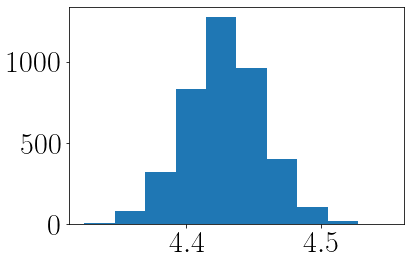

In [72]:
plt.hist(np.exp(trace["log_age"]));

In [32]:
map_soln["age"]

array(1.)

In [31]:
with age_model:
    trace = pm.sample(1000)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


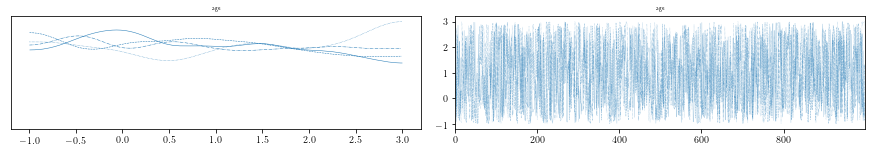

In [33]:
ax = pm.traceplot(trace);

In [28]:
pm.summary(trace).round(2)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age,1.01,1.16,-1.0,2.78,0.03,0.02,1543.0,1543.0,1607.0,1962.0,1.0


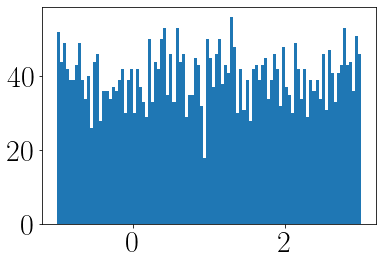

In [29]:
plt.hist(trace.age, 100);